*The following is a solution to the RSNA Screeening Mammography Breast Cancer Detection Dataset*

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split


import cv2

import time
import keras
import os
import logging
import random
import math

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on CPU or GPU')
    TPU = None

if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    STRATEGY = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    STRATEGY = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

#clear_output()
N_REPLICAS = STRATEGY.num_replicas_in_sync
print(f'N_REPLICAS: {N_REPLICAS}, IS_TPU: {IS_TPU}')


In [ ]:
# Image dimensions
IMG_HEIGHT = 1456
IMG_WIDTH = 728
N_CHANNELS = 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)
N_SAMPLES_TFRECORDS = 548

# Peak Learning Rate
EPOCHS = 15

# Batch size
BATCH_SIZE = 8 * N_REPLICAS


IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
VERBOSE = 1 if IS_INTERACTIVE else 2

# Tensorflow AUTO flag
AUTO = tf.data.experimental.AUTOTUNE

print(f'BATCH_SIZE: {BATCH_SIZE}')

In [ ]:
MIXED_PRECISION = False
DEVICE = 'TPU'

if MIXED_PRECISION:
    if 'TPU' in DEVICE:
        policy_type = 'mixed_bfloat16'
    else:
        policy_type = 'mixed_float16'
else:
    policy_type = 'float32'
policy = tf.keras.mixed_precision.Policy(policy_type)
tf.keras.mixed_precision.set_global_policy(policy)
print(f'Computation dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')

In [ ]:
# TFRecord file paths
tfrecords = sorted(tf.io.gfile.glob('/kaggle/input/dataset-rsna-bcd-1456x728-final-tfrecords/*.tfrecords'))
print(f'Found {len(tfrecords)} TFRecords')

In [112]:
def create_dataset(tfrecords):
    # Create dataset path/label
    dataset = tf.data.TFRecordDataset(tfrecords,num_parallel_reads=AUTO,compression_type='GZIP')

    # Decode mapping
    dataset = dataset.map(decoder, num_parallel_calls=AUTO)
    
    cancer_dataset = dataset.filter(cancer)
    non_cancer_dataset = dataset.filter(non_cancer)
    
    cancer_dataset = preprocess(cancer_dataset)
    non_cancer_dataset = preprocess(non_cancer_dataset)
    dataset = preprocess(dataset)
    
    cancer_dataset = cancer_dataset.map(return_image, num_parallel_calls=AUTO)
    non_cancer_dataset = non_cancer_dataset.map(return_images, num_parallel_calls=AUTO)
    
    return cancer_dataset, non_cancer_dataset, dataset

def preprocess(dataset):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def decoder(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64),
        'patient_id': tf.io.FixedLenFeature([], tf.int64)})
    img = tf.io.decode_png(features['image'], channels=N_CHANNELS)
    img = tf.reshape(img, [IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])
    img = img / 255
    img = tf.cast(img, tf.float32)
    label = features['target']
    return img, label

def cancer(img, label):
    return label == 1

def non_cancer(img, label):
    return label == 0

def return_images(img,label):
    return img, img

def return_image(img,label):
    return img


In [113]:
# Get Cancer/Non-Cancer datasets
c_dataset, nc_dataset, dataset = create_dataset(tfrecords)

In [114]:
TRAIN_STEPS_PER_EPOCH = (668+167) #batchsize = 64

In [ ]:
def return_label(img,label):
    return label
def return_image(img,label):
    return img


nc_images = nc_dataset.map(return_image, num_parallel_calls=AUTO)
nc_labels = nc_dataset.map(return_label, num_parallel_calls=AUTO)

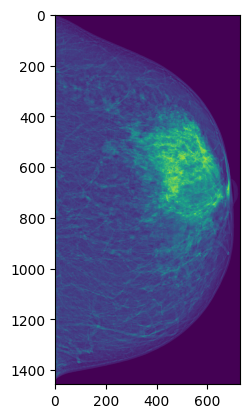

In [10]:
plt.imshow(next(iter(nc_dataset))[0][0].numpy())

In [115]:
# Sanity checking
def check_dataset(dataset):
    image, _ = next(iter(dataset))
    image = image.numpy()
    print(f"X_batch shape: {image.shape}")
    print(f"X_batch dtype: {image.dtype}")
    print(f"X_batch min: {image.min():.2f}, max: {image.max():.2f}")

check_dataset(nc_dataset)

X_batch shape: (8, 1456, 728, 1)
X_batch dtype: float32
X_batch min: 0.00, max: 1.00


# Model

In [116]:
def vaeloss(y_true, y_pred, mean, logvar):
    reconstruction_loss = K.sqrt(K.mean(K.square(y_true - y_pred), axis = [1,2,3])) * IMG_HEIGHT * IMG_WIDTH
    kl_loss =  -0.5 * K.sum(1 + logvar - keras.ops.square(mean) - K.exp(logvar), axis = 1)
    return K.mean(reconstruction_loss + kl_loss)
    

class CVAE(keras.Model):
    def __init__(self, latent_dim): 
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        inputs = keras.Input((IMG_HEIGHT, IMG_WIDTH, 1))
        x = keras.ops.image.resize(inputs, (1536,768))
        x = keras.layers.Conv2D(filters=32, kernel_size=7, strides=(2, 1), padding='same', activation='leaky_relu')(x)
        x = self.encoder_block(x, 64, 2)
        x = self.encoder_block(x, 128, 3)
        x = self.encoder_block(x, 256, 3)
        x = self.encoder_block(x, 512, 2)
        x = keras.layers.GlobalAveragePooling2D()(x)
        encoder_output = keras.layers.Dense(self.latent_dim + self.latent_dim)(x)
        mean, logvar = keras.ops.split(encoder_output, indices_or_sections=2, axis=1)
        self.encoder = keras.Model(inputs, (mean, logvar), name="encoder")

        # Decoder
        latent_inputs = keras.Input((self.latent_dim,))
        x = keras.layers.Dense(units=64*32*16)(latent_inputs)
        x = keras.layers.Reshape(target_shape=(64, 32, 16))(x)
        x = self.decoder_block(x, 256, 2)
        x = self.decoder_block(x, 128, 3)
        x = self.decoder_block(x, 64, 3)
        x = self.decoder_block(x, 32, 2)
        outputs = keras.layers.Conv2DTranspose(filters=1, kernel_size=7, strides=(2, 2), padding='same', activation='sigmoid')(x)
        outputs = keras.ops.image.resize(outputs, (1456,728))
        self.decoder = keras.Model(latent_inputs, outputs, name="decoder")

    
    def resblock(self, x, filters, encoder=True, stride=2, kernel_size=3):
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)
        fx = keras.layers.Conv2D(filters//2, kernel_size=1)(x)
        
        fx = keras.layers.BatchNormalization()(fx)
        fx = keras.layers.LeakyReLU()(fx)
        if encoder:   
            fx = keras.layers.Conv2D(filters//2, kernel_size, padding='same', strides=stride)(fx)
            x = keras.layers.Conv2D(filters, kernel_size=1, strides=stride)(x)
        else:
            fx = keras.layers.Conv2DTranspose(filters//2, kernel_size, padding='same', strides=stride)(fx)
            x = keras.layers.Conv2DTranspose(filters, kernel_size=1, strides=stride)(x)
            
        fx = keras.layers.BatchNormalization()(fx)
        fx = keras.layers.LeakyReLU()(fx)
        fx = keras.layers.Conv2D(filters, kernel_size=1)(fx)

        out = keras.layers.Add()([x, fx])
        return out
    
    def encoder_block(self, x, filters, blocks, encoder=True, stride=2, kernel_size=3):
        strides = [stride] + [1]*blocks
        for stride in strides:
            x = self.resblock(x, filters, encoder, stride)
        return x
            
    
    def decoder_block(self, x, filters, blocks, encoder=False, stride=2, kernel_size=3):
        strides = [stride] + [1]*blocks
        for stride in strides:
            x = self.resblock(x, filters, encoder, stride)
        return x
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * 0.5) + mean
    
    
    def get_config(self):
        return {"latent_dim": self.latent_dim}
    
    def save_model(self, filepath):
        self.save(filepath)

    def call(self,x):
        self.mean, self.logvar = self.encoder(x)
        output = self.decoder(self.reparameterize(self.mean, self.logvar))
        self.add_loss(vaeloss(x, output, self.mean, self.logvar))
        
        return output

In [ ]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit("autoclustering")

with STRATEGY.scope():    
    
    model = CVAE(1024)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    print(model.summary())
    history = model.fit(x=nc_dataset, epochs=60, steps_per_epoch=TRAIN_STEPS_PER_EPOCH)
    model.save_model("/kaggle/working/cvae_model_v3.keras")

In [15]:
'''!cp /kaggle/input/cvae_model_v2.keras/keras/default/1/cvae_model_v3.keras /kaggle/working/cvae_model_v2.keras
with STRATEGY.scope(): 
    #model.save_model("/kaggle/working/cvae_model_v2.keras")
    model1 = keras.models.load_model("/kaggle/working/cvae_model_v2.keras", custom_objects={'CVAE': CVAE})
    #history1 = model1.fit(x=nc_dataset, epochs=1, steps_per_epoch=TRAIN_STEPS_PER_EPOCH)'''

In [1]:
'''with STRATEGY.scope():  
    history = model.fit(x=nc_dataset, epochs=5, steps_per_epoch=TRAIN_STEPS_PER_EPOCH)
    model.save("/kaggle/working/cvae_model_v2.keras")'''

'with STRATEGY.scope():  \n    history = model.fit(x=nc_dataset, epochs=5, steps_per_epoch=TRAIN_STEPS_PER_EPOCH)\n    model.save("/kaggle/working/cvae_model_v2.keras")'

In [ ]:
def plot_predictions(model, validation_data):
    for x in validation_data.take(1):
        '''mean, logvar = model.encoder(test_x)
        z = model.reparameterize(mean, logvar)
        pred = model.decoder(z)'''
        pred = model(x)
        
        fig = plt.figure(figsize=(16, 16))

        for i in range(min(BATCH_SIZE,8)):
            plt.subplot(4, 4, i + 1)
            plt.imshow(pred[i,:,:,:], cmap='jet')
            plt.axis('off')
        plt.show()

        fig1 = plt.figure(figsize=(16, 16))

        for i in range(min(BATCH_SIZE,8)):
            plt.subplot(4, 4, i + 1)
            plt.imshow(x[i, :, :, ], cmap='jet')
            plt.axis('off')

        plt.show()
plot_predictions(model, nc_images)

In [ ]:
def undersample_majority(img, label):
    return label == 1 or tf.random.uniform([]) > 3/4

new_dataset = dataset.filter(undersample_majority)

In [ ]:
all_labels = []
all_scores = []

c = 0
for images, labels in new_dataset:  
    if c % 1000 == 0: 
        print(c)
    model1.mean, model1.logvar = model1.encoder(images)
    output = model1.decoder(model1.reparameterize(model1.mean, model1.logvar))
    anomaly_score = vaeloss(images, output, model1.mean, model1.logvar)
    
    all_labels.append(labels.numpy())  
    all_scores.append(anomaly_score.numpy()) 
    c += 1

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_scores = np.array(all_scores)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)

# Determine the optimal threshold
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

#x_pred = model1.predict(images.take(50))
#thr = threshold(x_pred, images.take(50), labels.take(50))


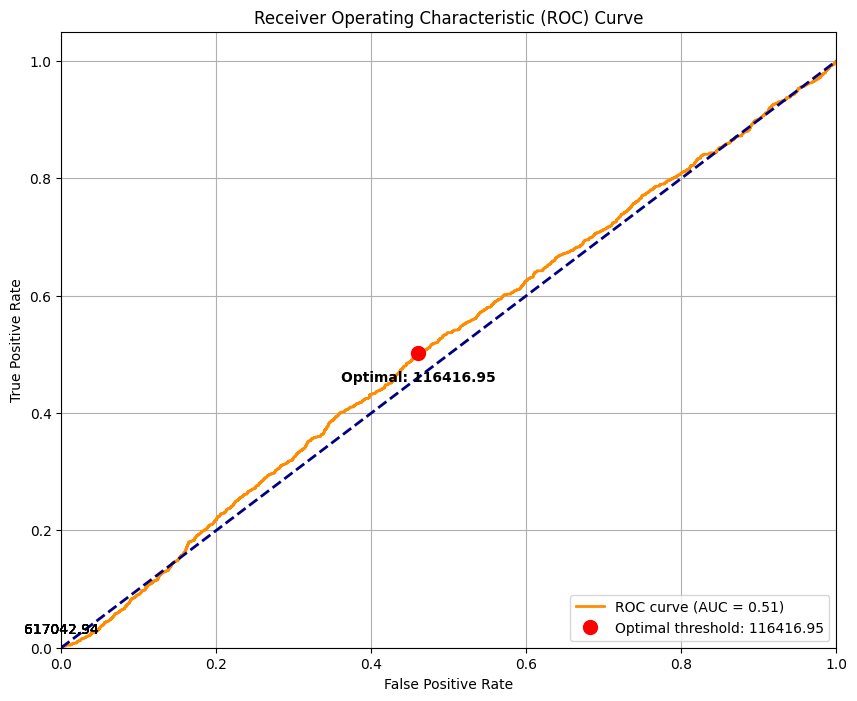

116416.945

In [31]:
from sklearn.metrics import auc

def plot_roc_curve(y_true, anomaly_scores):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, anomaly_scores)
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Add threshold annotations
    thresholds_to_show = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    idx = np.searchsorted(thresholds, thresholds_to_show)
    for i in idx:
        plt.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Find and mark the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, label=f'Optimal threshold: {optimal_threshold:.2f}')
    plt.annotate(f'Optimal: {optimal_threshold:.2f}', (fpr[optimal_idx], tpr[optimal_idx]), 
                 textcoords="offset points", xytext=(0,-20), ha='center', fontweight='bold')

    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return optimal_threshold

plot_roc_curve(all_labels, all_scores)

In [79]:
pred = list()
y = list()

for images, labels in new_dataset:  
    model1.mean, model1.logvar = model1.encoder(images)
    output = model1.decoder(model1.reparameterize(model1.mean, model1.logvar))
    error = vaeloss(images, output, model1.mean, model1.logvar)
    
    y.append(labels.numpy()[0])
    if error > optimal_threshold:
        pred.append(1)
    else:
        pred.append(0)


In [ ]:
def pfbeta(labels, predictions, beta=1):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        #prediction = min(max(predictions[idx], 0), 1)
        prediction = predictions[idx]

        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction
    print(y_true_count)
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

result = pfbeta(y,pred)
result

In [ ]:
'''for n, i in enumerate(y):
    if i == 1:
        print(n)'''